# 전이 학습 -> 딥러닝 성능 극대화

## 소규모 데이터셋 학습 모델

### 치매 환자 vs 일반인 예측

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 데이터 가져오기
!git clone https://github.com/taehojo/data-ch20.git

Cloning into 'data-ch20'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (265/265), done.
remote: Compressing objects: 100% (265/265), done.
remote: Total 265 (delta 0), reused 265 (delta 0), pack-reused 0
Receiving objects: 100% (265/265), 1.86 MiB | 7.11 MiB/s, done.


In [4]:
# 학습셋 변형 설정
train_datagen = ImageDataGenerator(rescale=1./255,          # 이미지 크기 설정
                                  horizontal_flip=True,     # 수평 대칭 이미지 50% 확률 추가
                                  width_shift_range=0.1,    # 전체 크기 15% 범위에서 좌우 이동
                                  height_shift_range=0.1,   # 위, 아래 이동
                                  #rotation_range=5,        # 정해진 각도만큼 회전
                                  #shear_range=0.7,         # 좌표 하나 고정 후 나머지 이동
                                  #zoom_range=1.2,          # 확대 / 축소
                                  #vertical_flip=True,      # 수직 대칭 이미지
                                  #fill_mode='nearest'      # 빈 공간 채우기 nearest 옵션 : 가장 비슷한 색.
                                  )      

train_generator = train_datagen.flow_from_directory(
       './data-ch20/train',   # 학습셋 폴더 위치
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 160 images belonging to 2 classes.


In [5]:
# 테스트셋 : 이미지 부풀리기 과정 진행 X
test_datagen = ImageDataGenerator(rescale=1./255)  

test_generator = test_datagen.flow_from_directory(
       './data-ch20/test',   # 테스트셋 있는 폴더 위치
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 120 images belonging to 2 classes.


In [6]:
# CNN 모델 적용
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

In [7]:
# 모델 실행 옵션 설정
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

In [8]:
# 학습 조기 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [9]:
# 모델 실행
history = model.fit(
       train_generator,
       epochs=100,
       validation_data=test_generator,
       validation_steps=10, 
       callbacks=[early_stopping_callback])

Epoch 1/100
32/32 [==============================] - 11s 40ms/step - loss: 0.6978 - accuracy: 0.4812 - val_loss: 0.6856 - val_accuracy: 0.5400
Epoch 2/100
32/32 [==============================] - 1s 34ms/step - loss: 0.6951 - accuracy: 0.5375 - val_loss: 0.6823 - val_accuracy: 0.6400
Epoch 3/100
32/32 [==============================] - 2s 51ms/step - loss: 0.6817 - accuracy: 0.6062 - val_loss: 0.6668 - val_accuracy: 0.6800
Epoch 4/100
32/32 [==============================] - 1s 46ms/step - loss: 0.6611 - accuracy: 0.6250 - val_loss: 0.6720 - val_accuracy: 0.5200
Epoch 5/100
32/32 [==============================] - 1s 43ms/step - loss: 0.6775 - accuracy: 0.6187 - val_loss: 0.6469 - val_accuracy: 0.6000
Epoch 6/100
32/32 [==============================] - 1s 46ms/step - loss: 0.6511 - accuracy: 0.6313 - val_loss: 0.6784 - val_accuracy: 0.5200
Epoch 7/100
32/32 [==============================] - 1s 40ms/step - loss: 0.5981 - accuracy: 0.7375 - val_loss: 0.4941 - val_accuracy: 0.8800
Epoch

In [10]:
# 데이터셋 오차 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

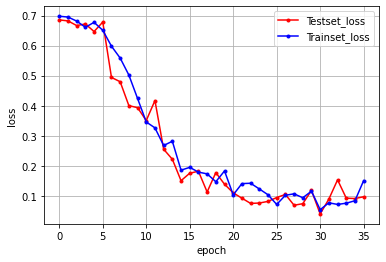

In [11]:
# 그래프 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그리드, 레이블 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 전이 학습 모델 성능 극대화

### 전이 학습 실습

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# 학습셋 변형 설정
train_datagen = ImageDataGenerator(rescale=1./255,          # 이미지 크기 설정
                                  horizontal_flip=True,     # 수평 대칭 이미지 50% 확률로 추가
                                  width_shift_range=0.1,    # 전체 크기의 15% 범위에서 좌우 이동
                                  height_shift_range=0.1,   # 위, 아래 이동
                                  #rotation_range=5,        # 정해진 각도만큼 회전
                                  #shear_range=0.7,         # 좌표 하나 고정, 나머지 이동
                                  #zoom_range=1.2,          # 확대, 축소
                                  #vertical_flip=True,      # 수직 대칭 이미지
                                  #fill_mode='nearest'      # 빈 공간 채우는 방법 nearest : 가장 비슷한 색
                                  )      


train_generator = train_datagen.flow_from_directory(
       './data-ch20/train',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 160 images belonging to 2 classes.


In [14]:
# 테스트셋 정규화 설정
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       './data-ch20/test',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 120 images belonging to 2 classes.


In [15]:
# VGG16 모델
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [16]:
# 모델 설정
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.5))
finetune_model.add(Dense(1))
finetune_model.add(Activation('sigmoid'))
finetune_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                524352    
                                                                 
 activation_5 (Activation)   (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
 activation_6 (Activation)   (None, 1)                

In [17]:
# 모델 실행 옵션 설정
finetune_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

In [18]:
# 학습 조기 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [19]:
# 모델 실행
history = finetune_model.fit(
       train_generator,
       epochs=20,
       validation_data=test_generator,
       validation_steps=10, 
       callbacks=[early_stopping_callback])

Epoch 1/20
32/32 [==============================] - 3s 47ms/step - loss: 0.7263 - accuracy: 0.5125 - val_loss: 0.5769 - val_accuracy: 0.8000
Epoch 2/20
32/32 [==============================] - 1s 41ms/step - loss: 0.5981 - accuracy: 0.6812 - val_loss: 0.5587 - val_accuracy: 0.7400
Epoch 3/20
32/32 [==============================] - 2s 50ms/step - loss: 0.4889 - accuracy: 0.7812 - val_loss: 0.4762 - val_accuracy: 0.8000
Epoch 4/20
32/32 [==============================] - 1s 40ms/step - loss: 0.4149 - accuracy: 0.8625 - val_loss: 0.3621 - val_accuracy: 0.9400
Epoch 5/20
32/32 [==============================] - 1s 41ms/step - loss: 0.4078 - accuracy: 0.8500 - val_loss: 0.3650 - val_accuracy: 0.9200
Epoch 6/20
32/32 [==============================] - 1s 46ms/step - loss: 0.3751 - accuracy: 0.8875 - val_loss: 0.2876 - val_accuracy: 0.9200
Epoch 7/20
32/32 [==============================] - 2s 47ms/step - loss: 0.3300 - accuracy: 0.9250 - val_loss: 0.3055 - val_accuracy: 0.9200
Epoch 8/20
32

In [20]:
# 데이터셋 오차 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

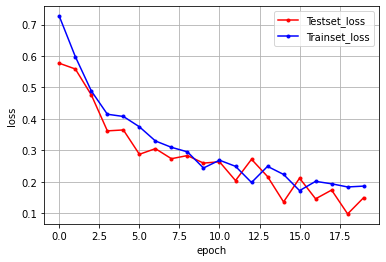

In [21]:
# 그래프 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그리드, 레이블 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()